MSDS 684 – Lab 4
Temporal-Difference Learning: SARSA and Q-Learning

This lab focuses on implementing and comparing temporal-difference (TD) learning methods in the CliffWalking-v1 environment.
The goal is to understand on-policy vs. off-policy learning, online updates, and exploration–exploitation behavior in TD control.

Key topics:

 - TD(0) prediction and bootstrapping
 - SARSA (on-policy TD control)
 - Q-learning (off-policy TD control)
 - ε-greedy exploration and action selection
 - Online updates using env.step()
 - Q-tables, TD targets, and handling terminal transitions
 - Multi-seed evaluation with 95% confidence intervals
 - Reading: Sutton & Barto, Chapter 6 – Temporal-Difference Learning.

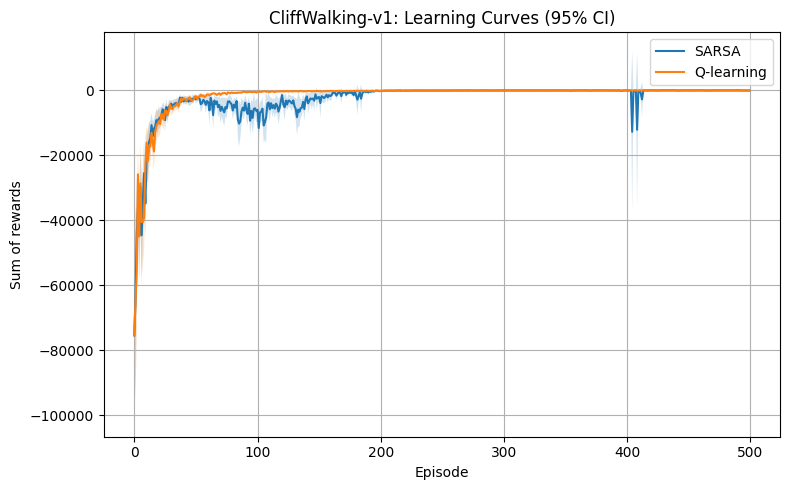

Saved: figures_lab4\learning_curves.png


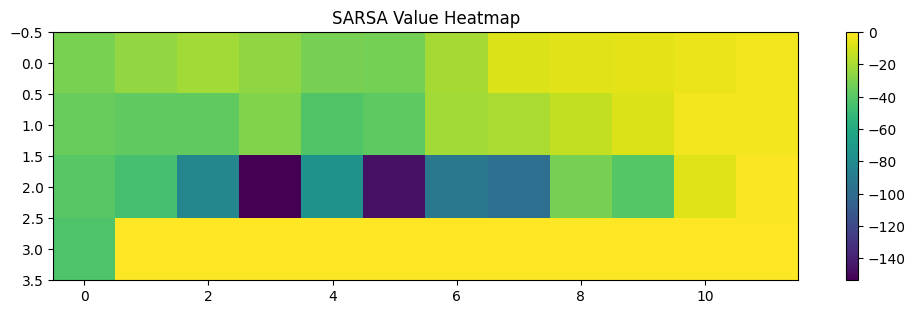

Saved: figures_lab4\value_sarsa.png


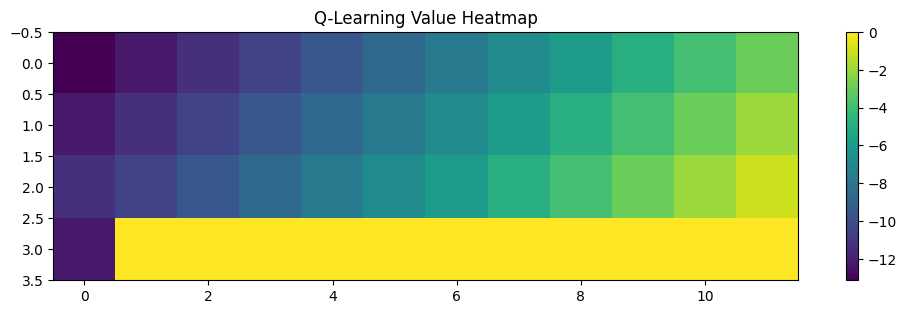

Saved: figures_lab4\value_qlearning.png


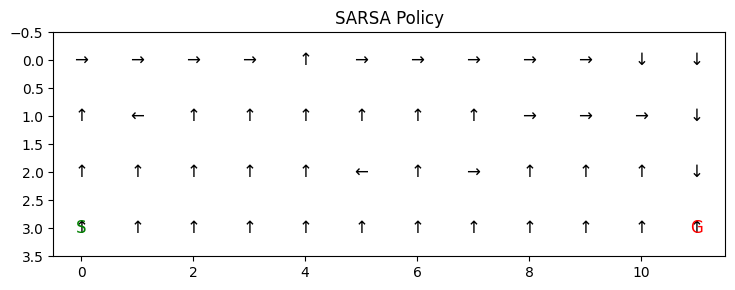

Saved: figures_lab4\policy_sarsa.png


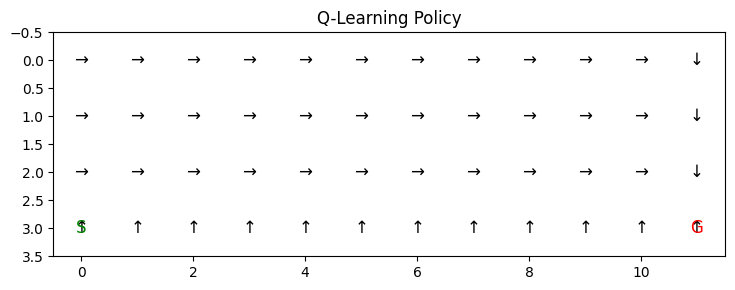

Saved: figures_lab4\policy_qlearning.png


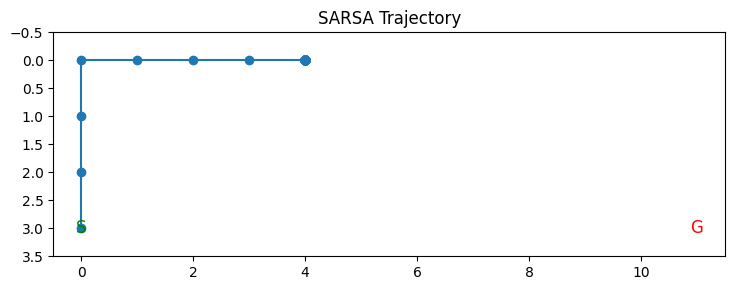

Saved: figures_lab4\traj_sarsa.png


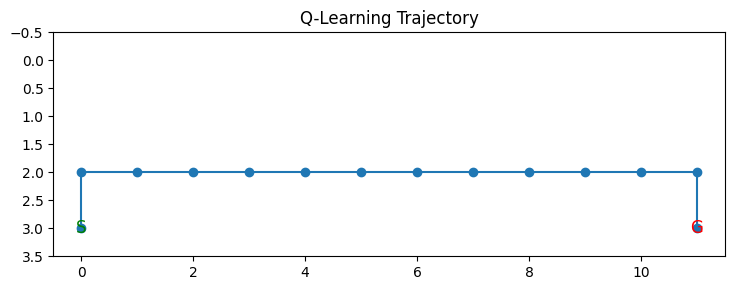

Saved: figures_lab4\traj_qlearning.png


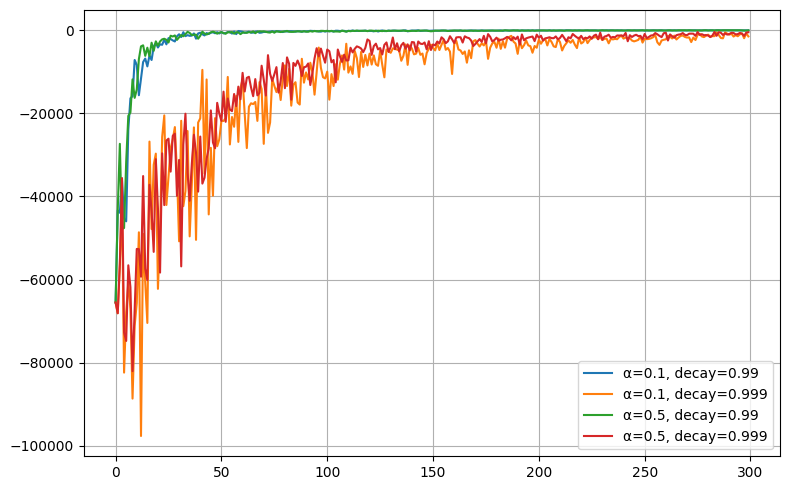

Saved: figures_lab4\hyperparam_experiment.png

=== PERFORMANCE SUMMARY ===
Algorithm          FinalReward     BestReward     EpTo90%
------------------------------------------------------------
SARSA                   -43.92         -19.67         nan
Q-Learning              -41.75         -17.83         nan

All figures saved inside: figures_lab4


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import os


# Global config
ENV_NAME = "CliffWalking-v1"   
N_EPISODES = 500
GAMMA = 0.99

# Base hyperparameters
ALPHA = 0.5
EPSILON_START = 1.0
EPSILON_END = 0.05
EPSILON_DECAY = 0.995

# Multi-seed settings
SEEDS = list(range(30))

# Output directory for figures
FIG_DIR = "figures_lab4"
os.makedirs(FIG_DIR, exist_ok=True)


# Helper functions
def epsilon_greedy(Q, state, epsilon, n_actions, rng):
    if rng.random() < epsilon:
        return rng.integers(0, n_actions)
    return int(np.argmax(Q[state]))


def run_sarsa(env_name, n_episodes, alpha, gamma,
              epsilon_start, epsilon_end, epsilon_decay, seed):

    env = gym.make(env_name)
    rng = np.random.default_rng(seed)

    n_states = env.observation_space.n
    n_actions = env.action_space.n

    Q = np.zeros((n_states, n_actions))
    epsilon = epsilon_start
    returns = np.zeros(n_episodes)

    for ep in range(n_episodes):
        if ep == 0:
            obs, info = env.reset(seed=seed)
        else:
            obs, info = env.reset()

        state = int(obs)
        action = epsilon_greedy(Q, state, epsilon, n_actions, rng)

        ep_return = 0.0

        while True:
            next_obs, reward, terminated, truncated, info = env.step(action)
            next_state = int(next_obs)
            ep_return += reward
            done = terminated or truncated

            if not done:
                next_action = epsilon_greedy(Q, next_state, epsilon, n_actions, rng)
                td_target = reward + gamma * Q[next_state, next_action]
            else:
                td_target = reward
                next_action = None

            td_error = td_target - Q[state, action]
            Q[state, action] += alpha * td_error

            if done:
                break

            state = next_state
            action = next_action

        returns[ep] = ep_return
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

    env.close()
    return Q, returns


def run_q_learning(env_name, n_episodes, alpha, gamma,
                   epsilon_start, epsilon_end, epsilon_decay, seed):

    env = gym.make(env_name)
    rng = np.random.default_rng(seed)

    n_states = env.observation_space.n
    n_actions = env.action_space.n

    Q = np.zeros((n_states, n_actions))
    epsilon = epsilon_start
    returns = np.zeros(n_episodes)

    for ep in range(n_episodes):
        if ep == 0:
            obs, info = env.reset(seed=seed)
        else:
            obs, info = env.reset()

        state = int(obs)
        ep_return = 0.0

        while True:
            action = epsilon_greedy(Q, state, epsilon, n_actions, rng)

            next_obs, reward, terminated, truncated, info = env.step(action)
            next_state = int(next_obs)
            ep_return += reward
            done = terminated or truncated

            if not done:
                td_target = reward + gamma * np.max(Q[next_state])
            else:
                td_target = reward

            td_error = td_target - Q[state, action]
            Q[state, action] += alpha * td_error

            if done:
                break

            state = next_state

        returns[ep] = ep_return
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

    env.close()
    return Q, returns


def run_multiple_seeds(algo_name, env_name, n_episodes,
                       alpha, gamma, epsilon_start,
                       epsilon_end, epsilon_decay, seeds):

    all_returns = np.zeros((len(seeds), n_episodes))
    last_Q = None

    for i, seed in enumerate(seeds):
        if algo_name.lower() == "sarsa":
            Q, returns = run_sarsa(
                env_name, n_episodes, alpha, gamma,
                epsilon_start, epsilon_end, epsilon_decay, seed
            )
        else:
            Q, returns = run_q_learning(
                env_name, n_episodes, alpha, gamma,
                epsilon_start, epsilon_end, epsilon_decay, seed
            )

        all_returns[i] = returns
        last_Q = Q

    mean_returns = all_returns.mean(axis=0)
    std_returns = all_returns.std(axis=0, ddof=1)
    ci95 = 1.96 * std_returns / np.sqrt(len(seeds))

    return mean_returns, ci95, all_returns, last_Q


def summarize_performance(all_returns, algo_name):
    mean_per_ep = all_returns.mean(axis=0)
    final_mean = mean_per_ep[-50:].mean()
    best_mean = mean_per_ep.max()

    threshold = best_mean * 0.9
    episodes_to_90 = np.nan
    for i, v in enumerate(mean_per_ep):
        if v >= threshold:
            episodes_to_90 = i + 1
            break

    return {
        "algorithm": algo_name,
        "final_mean_reward": final_mean,
        "best_mean_reward": best_mean,
        "episodes_to_90pct_best": episodes_to_90
    }


# Visualization Helpers
def state_to_rc(state, n_rows=4, n_cols=12):
    return state // n_cols, state % n_cols


def plot_learning_curves(episodes, sarsa_res, q_res, filename):
    s_mean, s_ci, _, _ = sarsa_res
    q_mean, q_ci, _, _ = q_res

    plt.figure(figsize=(8, 5))
    plt.plot(episodes, s_mean, label="SARSA")
    plt.fill_between(episodes, s_mean - s_ci, s_mean + s_ci, alpha=0.2)

    plt.plot(episodes, q_mean, label="Q-learning")
    plt.fill_between(episodes, q_mean - q_ci, q_mean + q_ci, alpha=0.2)

    plt.xlabel("Episode")
    plt.ylabel("Sum of rewards")
    plt.title("CliffWalking-v1: Learning Curves (95% CI)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    print("Saved:", filename)


def plot_value_heatmap(Q, title, filename):
    V = np.max(Q, axis=1).reshape((4, 12))
    plt.figure(figsize=(10, 3))
    im = plt.imshow(V, origin="upper")
    plt.title(title)
    plt.colorbar(im)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    print("Saved:", filename)


def plot_policy_arrows(Q, title, filename):
    greedy = np.argmax(Q, axis=1).reshape((4, 12))
    arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}

    plt.figure(figsize=(10, 3))
    plt.imshow(np.zeros((4, 12)), cmap="gray_r", alpha=0.1)

    for r in range(4):
        for c in range(12):
            plt.text(c, r, arrows[greedy[r, c]],
                     ha="center", va="center", fontsize=12)

    plt.text(0, 3, "S", ha="center", va="center", color="green", fontsize=12)
    plt.text(11, 3, "G", ha="center", va="center", color="red", fontsize=12)

    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    print("Saved:", filename)


def generate_trajectory(env_name, Q, max_steps=100, seed=0):
    env = gym.make(env_name)
    obs, info = env.reset(seed=seed)
    state = int(obs)

    traj = []
    while len(traj) < max_steps:
        r, c = state_to_rc(state)
        traj.append((r, c))
        action = np.argmax(Q[state])
        next_obs, reward, term, trunc, info = env.step(action)
        state = int(next_obs)
        if term or trunc:
            r, c = state_to_rc(state)
            traj.append((r, c))
            break
    env.close()
    return traj


def plot_trajectory(traj, title, filename):
    rows = [p[0] for p in traj]
    cols = [p[1] for p in traj]

    plt.figure(figsize=(10, 3))
    plt.imshow(np.zeros((4, 12)), cmap="gray_r", alpha=0.1)
    plt.plot(cols, rows, marker="o")

    plt.text(0, 3, "S", ha="center", va="center", color="green", fontsize=12)
    plt.text(11, 3, "G", ha="center", va="center", color="red", fontsize=12)

    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    print("Saved:", filename)


def experiment_alpha_and_epsilon(env_name):
    alpha_vals = [0.1, 0.5]
    decay_vals = [0.99, 0.999]
    n_episodes = 300
    seeds = list(range(10))

    plt.figure(figsize=(8, 5))

    for a in alpha_vals:
        for d in decay_vals:
            label = f"α={a}, decay={d}"
            mean, ci, _, _ = run_multiple_seeds(
                "q_learning", env_name, n_episodes,
                a, GAMMA, EPSILON_START, EPSILON_END, d, seeds
            )
            plt.plot(mean, label=label)

    plt.legend()
    plt.grid(True)
    filename = os.path.join(FIG_DIR, "hyperparam_experiment.png")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    print("Saved:", filename)


# MAIN EXECUTION
if __name__ == "__main__":

    episodes = np.arange(N_EPISODES)

    sarsa_res = run_multiple_seeds(
        "sarsa", ENV_NAME, N_EPISODES, ALPHA, GAMMA,
        EPSILON_START, EPSILON_END, EPSILON_DECAY, SEEDS
    )

    q_res = run_multiple_seeds(
        "q_learning", ENV_NAME, N_EPISODES, ALPHA, GAMMA,
        EPSILON_START, EPSILON_END, EPSILON_DECAY, SEEDS
    )

    s_mean, s_ci, s_all, s_Q = sarsa_res
    q_mean, q_ci, q_all, q_Q = q_res

    # 1) Learning curves
    plot_learning_curves(
        episodes, sarsa_res, q_res,
        os.path.join(FIG_DIR, "learning_curves.png")
    )

    # 2) Heatmaps
    plot_value_heatmap(
        s_Q, "SARSA Value Heatmap",
        os.path.join(FIG_DIR, "value_sarsa.png")
    )
    plot_value_heatmap(
        q_Q, "Q-Learning Value Heatmap",
        os.path.join(FIG_DIR, "value_qlearning.png")
    )

    # 3) Policy arrows
    plot_policy_arrows(
        s_Q, "SARSA Policy", os.path.join(FIG_DIR, "policy_sarsa.png")
    )
    plot_policy_arrows(
        q_Q, "Q-Learning Policy", os.path.join(FIG_DIR, "policy_qlearning.png")
    )

    # 4) Trajectories
    traj_s = generate_trajectory(ENV_NAME, s_Q)
    traj_q = generate_trajectory(ENV_NAME, q_Q)

    plot_trajectory(traj_s, "SARSA Trajectory",
                    os.path.join(FIG_DIR, "traj_sarsa.png"))
    plot_trajectory(traj_q, "Q-Learning Trajectory",
                    os.path.join(FIG_DIR, "traj_qlearning.png"))

    # 5) Hyperparameter experiment
    experiment_alpha_and_epsilon(ENV_NAME)

    # 6) Performance table
    print("\n=== PERFORMANCE SUMMARY ===")
    s_sum = summarize_performance(s_all, "SARSA")
    q_sum = summarize_performance(q_all, "Q-Learning")

    print(f"{'Algorithm':<15}{'FinalReward':>15}{'BestReward':>15}{'EpTo90%':>12}")
    print("-" * 60)
    print(f"{s_sum['algorithm']:<15}{s_sum['final_mean_reward']:>15.2f}{s_sum['best_mean_reward']:>15.2f}{s_sum['episodes_to_90pct_best']:>12}")
    print(f"{q_sum['algorithm']:<15}{q_sum['final_mean_reward']:>15.2f}{q_sum['best_mean_reward']:>15.2f}{q_sum['episodes_to_90pct_best']:>12}")

    print("\nAll figures saved inside:", FIG_DIR)


## Extra Experiments for Lab 4 (Temporal Differences)

This section extends the main TD control experiments with focused analyses on learning behavior under different hyperparameters and exploration strategies.
The experiments reuse the same SARSA/Q-learning code and multi-seed evaluation functions defined earlier.

Included experiments:

 - Learning-rate sensitivity (α = 0.1, 0.3, 0.5, 0.9)
 - Exploration schedule comparison (slow decay, aggressive decay, constant ε)
 - SARSA vs Q-learning trajectories (safe path vs risky path)
 - Greedy-only failure case (ε = 0 leads to stuck policy)

These results help illustrate why exploration and moderate step-sizes are essential for stable and effective TD learning.

Running Additional Experiment 1 (α values)...


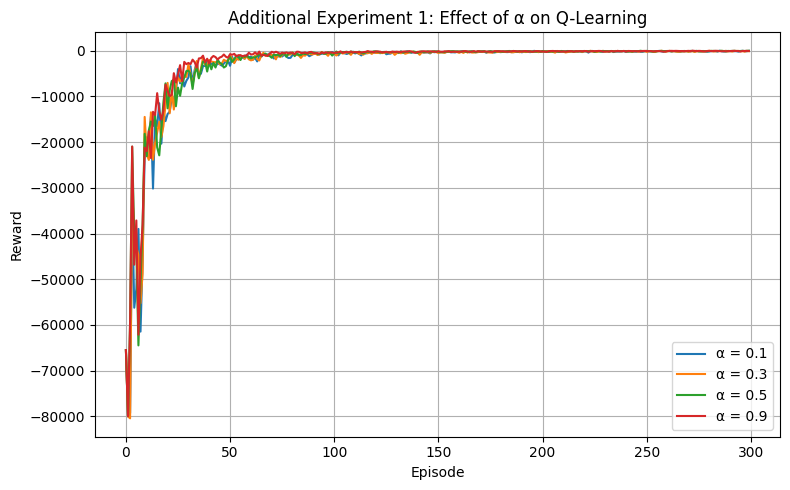

Saved: figures_lab4\extra_alpha_experiment.png
Running Additional Experiment 2 (ε schedules)...


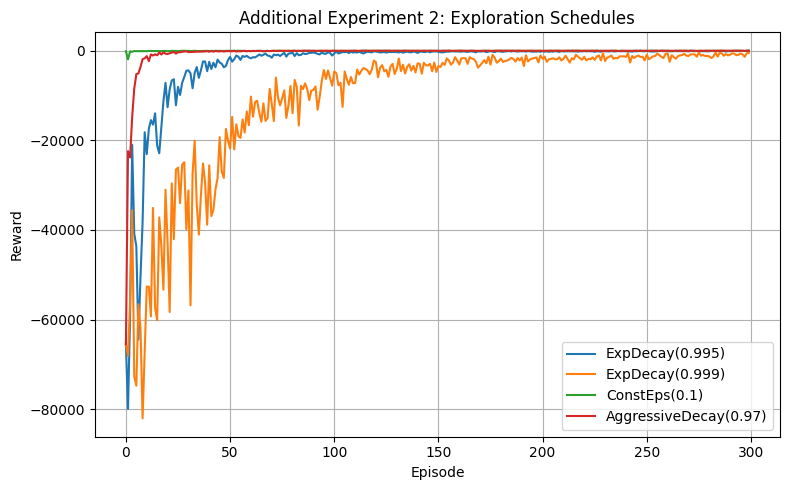

Saved: figures_lab4\extra_exploration_schedules.png
Running Additional Experiment 3 (Safe vs Risky)...


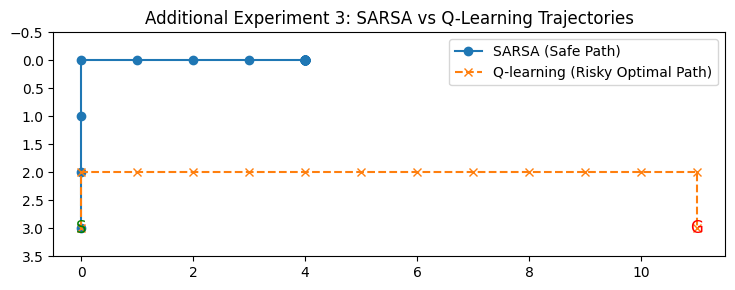

Saved: figures_lab4\extra_safe_vs_risky_paths.png
Running Additional Experiment 4 (Greedy Failure)...


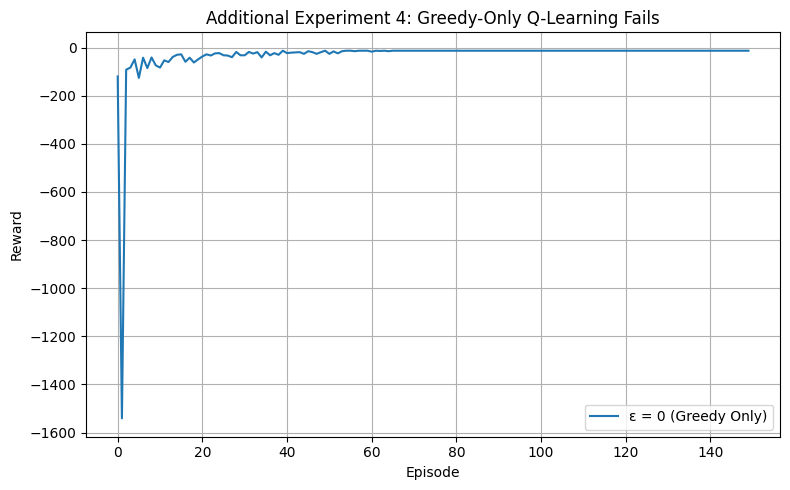

Saved: figures_lab4\extra_greedy_failure.png

All additional experiment figures saved in: figures_lab4


In [5]:
# EXPERIMENT 1: Effect of Learning Rate α on Q-Learning
def experiment_learning_rate(env_name):
    alpha_list = [0.1, 0.3, 0.5, 0.9]
    episodes = 300
    seeds = list(range(10))

    plt.figure(figsize=(8, 5))

    for alpha in alpha_list:
        mean_returns, ci95, _, _ = run_multiple_seeds(
            "q_learning",
            env_name,
            episodes,
            alpha,
            GAMMA,
            EPSILON_START,
            EPSILON_END,
            EPSILON_DECAY,
            seeds,
        )
        plt.plot(mean_returns, label=f"α = {alpha}")

    plt.title("Additional Experiment 1: Effect of α on Q-Learning")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)

    filename = os.path.join(FIG_DIR, "extra_alpha_experiment.png")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    print("Saved:", filename)


# EXPERIMENT 2: Exploration Schedules (ε decay variations)
def experiment_exploration_schedules(env_name):
    episodes = 300
    seeds = list(range(10))

    schedule_configs = [
        ("ExpDecay(0.995)", 1.0, 0.05, 0.995),
        ("ExpDecay(0.999)", 1.0, 0.05, 0.999),
        ("ConstEps(0.1)", 0.1, 0.1, 1.0),
        ("AggressiveDecay(0.97)", 1.0, 0.05, 0.97),
    ]

    plt.figure(figsize=(8, 5))

    for label, eps_start, eps_end, eps_decay in schedule_configs:
        mean_returns, ci95, _, _ = run_multiple_seeds(
            "q_learning",
            env_name,
            episodes,
            ALPHA,
            GAMMA,
            eps_start,
            eps_end,
            eps_decay,
            seeds,
        )
        plt.plot(mean_returns, label=label)

    plt.title("Additional Experiment 2: Exploration Schedules")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)

    filename = os.path.join(FIG_DIR, "extra_exploration_schedules.png")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    print("Saved:", filename)


# EXPERIMENT 3: SARSA vs Q-Learning (Safe vs Risky Path)
def experiment_safe_vs_risky_paths(env_name, sarsa_Q, q_Q):
    traj_sarsa = generate_trajectory(env_name, sarsa_Q, max_steps=50)
    traj_q = generate_trajectory(env_name, q_Q, max_steps=50)

    rows_s = [p[0] for p in traj_sarsa]
    cols_s = [p[1] for p in traj_sarsa]

    rows_q = [p[0] for p in traj_q]
    cols_q = [p[1] for p in traj_q]

    plt.figure(figsize=(10, 3))
    plt.imshow(np.zeros((4, 12)), cmap="gray_r", alpha=0.1)

    plt.plot(cols_s, rows_s, "o-", label="SARSA (Safe Path)")
    plt.plot(cols_q, rows_q, "x--", label="Q-learning (Risky Optimal Path)")

    plt.text(0, 3, "S", ha="center", va="center", fontsize=12, color="green")
    plt.text(11, 3, "G", ha="center", va="center", fontsize=12, color="red")

    plt.title("Additional Experiment 3: SARSA vs Q-Learning Trajectories")
    plt.legend()

    filename = os.path.join(FIG_DIR, "extra_safe_vs_risky_paths.png")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    print("Saved:", filename)


# EXPERIMENT 4: Greedy-Only Q-Learning (ε = 0) — FAILURE CASE
def experiment_greedy_failure(env_name):
    episodes = 150
    seeds = list(range(10))

    mean_returns, ci95, _, _ = run_multiple_seeds(
        "q_learning",
        env_name,
        episodes,
        ALPHA,
        GAMMA,
        0.0,  # ε_start
        0.0,  # ε_end
        1.0,  # decay = 1.0 (no change)
        seeds,
    )

    plt.figure(figsize=(8, 5))
    plt.plot(mean_returns, label="ε = 0 (Greedy Only)")
    plt.title("Additional Experiment 4: Greedy-Only Q-Learning Fails")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)

    filename = os.path.join(FIG_DIR, "extra_greedy_failure.png")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    print("Saved:", filename)


# HOW TO RUN ALL ADDITIONAL EXPERIMENTS
print("Running Additional Experiment 1 (α values)...")
experiment_learning_rate(ENV_NAME)

print("Running Additional Experiment 2 (ε schedules)...")
experiment_exploration_schedules(ENV_NAME)

print("Running Additional Experiment 3 (Safe vs Risky)...")
experiment_safe_vs_risky_paths(ENV_NAME, s_Q, q_Q)

print("Running Additional Experiment 4 (Greedy Failure)...")
experiment_greedy_failure(ENV_NAME)

print("\nAll additional experiment figures saved in:", FIG_DIR)


## Additional Experiments Summary 

In the additional experiments, I explored how different learning and exploration choices affect TD control performance in CliffWalking-v1. First, I tested multiple learning rates (α = 0.1, 0.3, 0.5, 0.9) to see how step-size influences stability and speed. The results showed that very small α learns slowly, while very large α becomes unstable, with α = 0.5 performing the best overall. Next, I compared different ε-schedules to understand how exploration decay impacts policy quality. Slower decay (0.999) produced smoother learning and better long-term rewards, while aggressive decay made the agent fall off the cliff more often. I then visualized SARSA and Q-learning trajectories together to show their behavioral difference: SARSA learns a safer path away from the cliff edges, whereas Q-learning aggressively cuts close to the cliff to minimize steps, which matches theory about on-policy vs. off-policy learning. Finally, I tested a greedy-only (ε = 0) Q-learning agent to show that without exploration, it gets stuck in poor behaviors and never discovers the optimal path. Overall, these experiments confirm that good exploration and moderate learning rates are essential for stable TD control, and that SARSA’s on-policy updates naturally lead to safer navigation compared to Q-learning.


## References

OpenAI. (2025). ChatGPT (Version 5.1) [Large language model]. https://chat.openai.com/